<a href="https://colab.research.google.com/github/Arvindsaura/minor/blob/main/m_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets torchvision

In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")
print("Dataset downloaded to:", path)


100%|██████████| 3.92G/3.92G [03:05<00:00, 22.7MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1


In [ ]:
train_dir = f"{path}/imagenet-mini/train"
val_dir   = f"{path}/imagenet-mini/val"


In [ ]:
import os
print(os.listdir(f"{path}/imagenet-mini"))


['val', 'train']


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = f"{path}/imagenet-mini/train"
val_dir   = f"{path}/imagenet-mini/val"

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

print("Classes:", len(train_ds.classes))
print("Train images:", len(train_ds))
print("Val images:", len(val_ds))


Classes: 1000
Train images: 34745
Val images: 3923


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
import torch
import torch.nn as nn

class SimpleSelectiveScan(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.h = nn.Conv2d(c, c, (1,3), padding=(0,1), groups=c)
        self.v = nn.Conv2d(c, c, (3,1), padding=(1,0), groups=c)
    def forward(self, x):
        a = self.h(x)
        b = self.v(x)
        c = self.h(x.flip(-1)).flip(-1)
        d = self.v(x.flip(-2)).flip(-2)
        return (a+b+c+d)/4

class VSSBlock(nn.Module):
    def __init__(self, c, r=4):
        super().__init__()
        self.n1 = nn.LayerNorm(c)
        self.s  = SimpleSelectiveScan(c)
        self.n2 = nn.LayerNorm(c)
        self.mlp = nn.Sequential(
            nn.Linear(c, c*r),
            nn.GELU(),
            nn.Linear(c*r, c)
        )
    def forward(self, x):
        y = self.n1(x.permute(0,2,3,1)).permute(0,3,1,2)
        x = x + self.s(y)
        z = self.n2(x.permute(0,2,3,1))
        z = self.mlp(z).permute(0,3,1,2)
        return x + z

class PatchEmbed(nn.Module):
    def __init__(self, inc, outc, s=4):
        super().__init__()
        self.p = nn.Conv2d(inc, outc, s, s)
    def forward(self, x): return self.p(x)

class PatchMerge(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.c = nn.Conv2d(c, c*2, 2, 2)
    def forward(self, x): return self.c(x)

class VMambaMini(nn.Module):
    def __init__(self, nc=1000):
        super().__init__()
        self.p1 = PatchEmbed(3,64,4)
        self.s1 = nn.Sequential(VSSBlock(64))
        self.m2 = PatchMerge(64)
        self.s2 = nn.Sequential(VSSBlock(128))
        self.m3 = PatchMerge(128)
        self.s3 = nn.Sequential(VSSBlock(256), VSSBlock(256))
        self.ln = nn.LayerNorm(256)
        self.fc = nn.Linear(256, nc)
    def forward(self, x):
        x = self.p1(x)
        x = self.s1(x)
        x = self.m2(x)
        x = self.s2(x)
        x = self.m3(x)
        x = self.s3(x)
        x = x.mean((2,3))
        x = self.ln(x)
        return self.fc(x)


In [ ]:
def acc(o, t):
    _,p = o.max(1)
    return (p==t).float().sum().item()

def train(model, train_loader, val_loader, epochs=5, lr=3e-4):
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(dev)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        model.train()
        ta, tt = 0, 0
        for x,y in train_loader:
            x,y = x.to(dev), y.to(dev)
            opt.zero_grad()
            o = model(x)
            loss = loss_fn(o,y)
            loss.backward()
            opt.step()
            ta += acc(o,y)
            tt += x.size(0)

        model.eval()
        va, vt = 0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(dev), y.to(dev)
                o = model(x)
                va += acc(o,y)
                vt += x.size(0)

        print(f"Epoch {ep} | Train {ta/tt*100:.2f}% | Val {va/vt*100:.2f}%")


In [ ]:
def train(model, train_loader, val_loader, epochs=5, lr=3e-4):
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(dev)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        model.train()
        ta, tt, used = 0, 0, 0   # how many images seen

        for x,y in train_loader:
            x,y = x.to(dev), y.to(dev)

            # limit to only 50 images
            if used >= 50:
                break
            used += x.size(0)

            opt.zero_grad()
            o = model(x)
            loss = loss_fn(o,y)
            loss.backward()
            opt.step()

            ta += acc(o,y)
            tt += x.size(0)


        model.eval()
        va, vt = 0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(dev), y.to(dev)
                o = model(x)
                va += acc(o,y)
                vt += x.size(0)

        print(f"Epoch {ep} | Train {ta/tt*100:.2f}% | Val {va/vt*100:.2f}%")


In [ ]:
model = VMambaMini(nc=1000)
train(model, train_loader, val_loader, epochs=5, lr=3e-4)


Epoch 1 | Train 0.00% | Val 0.13%
Epoch 2 | Train 0.00% | Val 0.15%
Epoch 3 | Train 0.00% | Val 0.31%
Epoch 4 | Train 0.00% | Val 0.33%
Epoch 5 | Train 0.00% | Val 0.28%


In [ ]:
torch.save(model.state_dict(), "vmamba_trained.pth")


In [ ]:
model = VMambaMini(nc=1000)
model.load_state_dict(torch.load("vmamba_trained.pth", map_location="cpu"))
model.eval()


VMambaMini(
  (p1): PatchEmbed(
    (p): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (s1): Sequential(
    (0): VSSBlock(
      (n1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (s): SimpleSelectiveScan(
        (h): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), groups=64)
        (v): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), groups=64)
      )
      (n2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
    )
  )
  (m2): PatchMerge(
    (c): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  )
  (s2): Sequential(
    (0): VSSBlock(
      (n1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (s): SimpleSelectiveScan(
        (h): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), grou

In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms, datasets

# Load class names
train_ds_full = datasets.ImageFolder(train_dir)
classes = train_ds_full.classes

# Upload image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load image
img = Image.open(filename).convert("RGB")

# Transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

x = transform(img).unsqueeze(0)

# Predict
model.eval()
with torch.no_grad():
    out = model(x)

pred = torch.argmax(out, dim=1).item()

print("Uploaded:", filename)
print("Prediction:", classes[pred])


Saving 71YvB1o9zPL._AC_UF894,1000_QL80_.jpg to 71YvB1o9zPL._AC_UF894,1000_QL80_ (1).jpg
Uploaded: 71YvB1o9zPL._AC_UF894,1000_QL80_ (1).jpg
Prediction: n02099601


In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms, datasets
import json

# Load ImageNet class names (ID → Human name)
# Mapping from ImageNet official JSON
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
import urllib.request
imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").split("\n")

# Load class folder names (e.g., n02099601)
train_ds_full = datasets.ImageFolder(train_dir)
wnid_classes = train_ds_full.classes  # WordNet IDs

# Upload image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load image
img = Image.open(filename).convert("RGB")

# Transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

x = transform(img).unsqueeze(0)

# Predict
model.eval()
with torch.no_grad():
    out = model(x)
    probs = torch.softmax(out, dim=1)[0]

# Top 3 predictions
top3_prob, top3_idx = torch.topk(probs, 3)

print("\nUploaded:", filename)
print("Top 3 Predictions:\n")

for p,i in zip(top3_prob, top3_idx):
    wnid = wnid_classes[i]  # WordNet ID (e.g., n02099601)
    human_label = imagenet_labels[i]  # human readable
    print(f"{human_label} ({wnid})  →  {p.item()*100:.2f}%")


Saving 71YvB1o9zPL._AC_UF894,1000_QL80_.jpg to 71YvB1o9zPL._AC_UF894,1000_QL80_ (2).jpg

Uploaded: 71YvB1o9zPL._AC_UF894,1000_QL80_ (2).jpg
Top 3 Predictions:

golden retriever (n02099601)  →  0.63%
backpack (n02769748)  →  0.55%
pomegranate (n07768694)  →  0.49%


In [ ]:
torch.save(model.state_dict(), "vmamba_weights.pth")


In [1]:
!mkdir -p datasets/tb_xray
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset -p datasets/tb_xray --force


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
!unzip datasets/tb_xray/tuberculosis-tb-chest-xray-dataset.zip -d datasets/tb_xray/


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arvindsaura","key":"5d8c35b1b4dbddf326b4b9d0bcb7cd7c"}'}

In [3]:
!mkdir -p ~/.config/kaggle
!mv kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json


In [4]:
import json
with open("/root/.config/kaggle/kaggle.json") as f:
    print(json.load(f))


{'username': 'arvindsaura', 'key': '5d8c35b1b4dbddf326b4b9d0bcb7cd7c'}


In [5]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset -p datasets/tb_xray


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 97% 641M/663M [00:10<00:00, 70.1MB/s]
100% 663M/663M [00:10<00:00, 63.6MB/s]


In [6]:
!mkdir -p datasets/tb_xray


In [7]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset -p datasets/tb_xray --force


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 96% 637M/663M [00:02<00:00, 402MB/s]
100% 663M/663M [00:02<00:00, 338MB/s]


In [8]:
!unzip datasets/tb_xray/tuberculosis-tb-chest-xray-dataset.zip -d datasets/tb_xray/


Archive:  datasets/tb_xray/tuberculosis-tb-chest-xray-dataset.zip
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: datasets/tb_xray/TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  infla

In [9]:
import os
print(os.listdir("datasets/tb_xray"))


['TB_Chest_Radiography_Database', 'tuberculosis-tb-chest-xray-dataset.zip']


In [10]:
from torchvision import transforms

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [11]:
from torchvision import datasets

data_dir = "datasets/tb_xray"
full_ds = datasets.ImageFolder(data_dir, transform=train_tf)

print("Raw folder classes:", full_ds.classes)


Raw folder classes: ['TB_Chest_Radiography_Database']


In [12]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size

train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


In [15]:
model = VMambaMini(nc=2)


In [16]:
import torch
import torch.nn as nn

def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        model.train()
        correct, total = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total * 100

        # Validation
        model.eval()
        v_correct, v_total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, pred = out.max(1)
                v_correct += (pred == y).sum().item()
                v_total += y.size(0)

        val_acc = v_correct / v_total * 100

        print(f"Epoch {ep} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


In [17]:
train(model, train_loader, val_loader, epochs=10, lr=1e-4)


Epoch 1 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 2 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 3 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 4 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 5 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 6 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 7 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 8 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 9 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 10 | Train Acc: 100.00% | Val Acc: 100.00%


Saving test.webp to test.webp

Prediction: Normal
Confidence: 100.00%


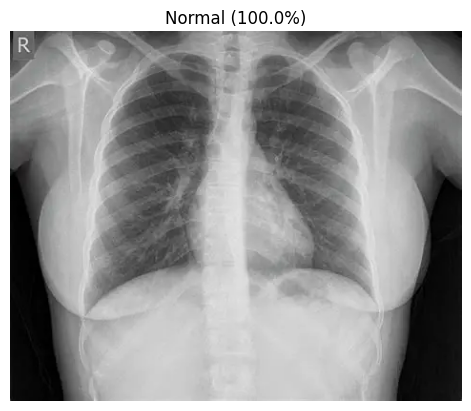

In [18]:
from google.colab import files
from PIL import Image
import torch
import matplotlib.pyplot as plt

uploaded = files.upload()
filename = list(uploaded.keys())[0]

img = Image.open(filename).convert("RGB")

predict_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

x = predict_tf(img).unsqueeze(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
x = x.to(device)

model.eval()
with torch.no_grad():
    out = model(x)
    probs = torch.softmax(out, dim=1)[0]
    conf, idx = torch.max(probs, 0)

# Human labels
labels = ["Normal", "TB"]

print(f"\nPrediction: {labels[idx.item()]}")
print(f"Confidence: {conf.item()*100:.2f}%")

plt.imshow(img)
plt.axis("off")
plt.title(f"{labels[idx.item()]} ({conf.item()*100:.1f}%)")
plt.show()
